**Goal**

The goal of this notebook is to see how mutual information develops in an online continual learner. We will be using the MNIST dataset, broken down into different tasks.

In [19]:
#@title Import Modules
import math
import functools

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn.functional as F
import torchvision.models as models

from collections import Counter
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

In [10]:
#@title Define Hyperparameters
if(torch.backends.mps.is_available()):
    device = 'mps'
elif (torch.cuda.is_available()):
    device = 'cuda'
else:
    device = 'cpu'

# Experiment parameters
pretrain      = True
tasks         = [[0,2], [5,6], [3,8]]
if pretrain:
    epochs    = 10
    numMI     = epochs + len(tasks) - 1
else:
    epochs    = 1
    numMI     = len(tasks)

# Pretraining parameters
lr            = 7e-2
milestones    = [epochs//2]
gamma         = 0.5
batch_size    = 512
momentum      = 0
weight_decay  = 0
# Online learning parameters
lr_ol         = (1/np.arange(1, len(tasks)+1)) * 4e-4
print(lr_ol)
# Measurement variables
n_bins        = 100

[0.0004     0.0002     0.00013333]


In [11]:
pca_components = 12

#@title Load data
#@title Data Retrieval
def process_dataset(data, task):
    conditions = []
    for c in task:
      conditions.append((data.targets == c))
    indices = functools.reduce(torch.logical_or, conditions)
    data.data, data.targets = data.data[indices], data.targets[indices]
    for i in range(len(task)):
      data.targets[data.targets == task[i]] = i
    data = TensorDataset(data.data.reshape(-1, 28*28), data.targets)
    return data

transform = transforms.ToTensor()


# Construct data
train_loaders = []
MI_loaders    = []
test_loaders  = []

for taskNum in range(len(tasks)):
  train_dataset = process_dataset(datasets.MNIST('../data', download=True, train=True, transform=transform), tasks[taskNum])
  MI_dataset    = process_dataset(datasets.MNIST('../data', download=True, train=True, transform=transform), sum(tasks[:taskNum+1], []))
  test_dataset  = process_dataset(datasets.MNIST('../data', download=True, train=False, transform=transform), tasks[taskNum])

  # use PCA to reduce to lower dimensions
  pca = PCA(n_components=pca_components)
  pca.fit(train_dataset.tensors[0])
  train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
  MI_dataset.tensors    = (torch.from_numpy(pca.transform(MI_dataset.tensors[0])).float(), MI_dataset.tensors[1])
  test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])

  # dataset loaders
  if pretrain and taskNum == 0:
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  else:
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, drop_last=True)

  MI_loader_temp = torch.utils.data.DataLoader(
      MI_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  MI_loader = torch.utils.data.DataLoader(
      MI_dataset, batch_size=len(MI_loader_temp.dataset), shuffle=False, drop_last=False)

  test_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  test_loader_full = torch.utils.data.DataLoader(
      test_dataset, batch_size = len(test_loader.dataset), shuffle=False, drop_last=False)
  # save loaders
  train_loaders.append(train_loader)
  MI_loaders.append(MI_loader)
  test_loaders.append(test_loader_full)

In [12]:
#@title Define Model
class Model(nn.Module):
    def __init__(self):
      super(Model, self).__init__()
      self.fc1 = nn.Linear(pca_components, 10)
      self.fc2 = nn.Linear(10, 7)
      self.fc3 = nn.Linear(7, 5)
      self.fc4 = nn.Linear(5, 4)
      self.fc5 = nn.Linear(4, 3)
      self.is_online = True

    def forward(self, x):
      h1 = torch.tanh(self.fc1(x))
      h2 = torch.tanh(self.fc2(h1))
      h3 = torch.tanh(self.fc3(h2))
      h4 = torch.tanh(self.fc4(h3))
      h5 = torch.tanh(self.fc5(h4))
      return h1, h2, h3, h4, h5

In [13]:
# Model setup
model       = Model().to(device)
class_heads = {i : nn.Linear(3, len(tasks[0])).to(device) for i in range(len(tasks))}
loss_function = nn.NLLLoss()

#@title Pre-Train Model
train_accuracy      = []
test_set_accuracy   = {}
firstOnlineTask     = 0

# Mutual information metrics
layers              = len(list(model.children())) + 1
MI_XH               = torch.zeros(numMI, layers)
MI_YH               = torch.zeros(numMI, layers)
if pretrain:
    print("Pre-training on task number 1")
    firstOnlineTask = 1
    optimizer       = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

    scheduler       = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    for epoch in range(epochs):
        print("   Epoch:", epoch+1, "/", epochs)
        # train phase
        print("       Training")
        model.train()
        accuracy = 0
        N = 0

        # iterate over train data
        for batch_idx, (images, labels) in enumerate(train_loaders[0], start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5 = model(images)
            h6 = F.log_softmax(class_heads[0](h5), dim = 1)
            loss = loss_function(h6, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]
        train_accuracy.append(100. * accuracy/N)
        scheduler.step()

        # iterate over test data
        print("       Evaluating test 1 / 1: ", end="")
        model.eval()
        accuracy = 0
        N = 0
        for batch_idx, (images, labels) in enumerate(test_loaders[0], start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5 = model(images)
            h6 = F.log_softmax(class_heads[0](h5), dim = 1)

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]
        test_set_accuracy[(0,0)] = 100. * accuracy/N
        print(accuracy, "/", N)

        for images, labels in MI_loaders[0]:
            images, labels = images.to(device), labels.to(device)

        h_list = model(images)
        h_list = h_list + (F.log_softmax(class_heads[0](h_list[-1]), dim=1), )

        # calculate mutual information
        print("       Computing mutual information")
        for layer, h in enumerate(h_list):
            # discretize images and representations
            bins = np.linspace(0, 1, n_bins+1)
            x_ = np.digitize(images.cpu(), bins)
            if layer == layers-1:
                h = torch.exp(h)
                bins = np.linspace(0, 1, n_bins+1)
            else:
                bins = np.linspace(-1, 1, n_bins+1)
            h_ = np.digitize(h.cpu().detach().numpy(), bins)
            y_ = labels.cpu()

            # calculate discrete probabilities
            p_X = Counter()
            p_Y = Counter()
            p_H = Counter()
            p_XH = Counter()
            p_YH = Counter()

            for x_i, h_i, y_i in zip(x_, h_, y_):
                def totuple(a):
                    try:
                        return tuple(totuple(i) for i in a)
                    except:
                        return a.item()

                unit = 1./len(images)

                p_X[totuple(x_i)]                   += unit
                p_Y[totuple(y_i)]                   += unit
                p_H[totuple(h_i)]                   += unit
                p_XH[(totuple(x_i), totuple(h_i))]  += unit
                p_YH[(totuple(y_i), totuple(h_i))]  += unit

            for xh in p_XH:
                if p_XH[xh] != 0:
                    MI_XH[epoch][layer] += p_XH[xh] * math.log2(p_XH[xh] / (p_X[xh[0]] * p_H[xh[1]]))

            for yh in p_YH:
                if p_YH[yh] != 0:
                    MI_YH[epoch][layer] += p_YH[yh] * math.log2(p_YH[yh] / (p_Y[yh[0]] * p_H[yh[1]]))
    firstOnlineTask = 1

Pre-training on task number 1
   Epoch: 1 / 10
       Training
       Evaluating test 1 / 1: 1704.0 / 2012
       Computing mutual information
   Epoch: 2 / 10
       Training
       Evaluating test 1 / 1: 1865.0 / 2012
       Computing mutual information
   Epoch: 3 / 10
       Training
       Evaluating test 1 / 1: 1930.0 / 2012
       Computing mutual information
   Epoch: 4 / 10
       Training
       Evaluating test 1 / 1: 1951.0 / 2012
       Computing mutual information
   Epoch: 5 / 10
       Training
       Evaluating test 1 / 1: 1959.0 / 2012
       Computing mutual information
   Epoch: 6 / 10
       Training
       Evaluating test 1 / 1: 1963.0 / 2012
       Computing mutual information
   Epoch: 7 / 10
       Training
       Evaluating test 1 / 1: 1966.0 / 2012
       Computing mutual information
   Epoch: 8 / 10
       Training
       Evaluating test 1 / 1: 1968.0 / 2012
       Computing mutual information
   Epoch: 9 / 10
       Training
       Evaluating test 1 / 1: 197

In [14]:
#@title Online Learn
for taskNum in range(firstOnlineTask, len(tasks)):
    print("Task Number:", taskNum+1, "/", len(tasks))
    optimizer = optim.SGD(model.parameters(),
                      lr=lr_ol[taskNum],
                      momentum=momentum,
                      weight_decay=weight_decay)

    # train phase
    print("   Training")
    model.train()
    accuracy = 0
    N = 0

    # iterate over train data
    for training_sample, (images, labels) in enumerate(train_loaders[taskNum], start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5 = model(images)
        h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)
        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]
    train_accuracy.append(100. * accuracy/N)

    # test phase
    model.eval()

    # iterate over test data
    for testTaskNum in range(taskNum+1):
        print("   Evaluating test", testTaskNum+1, "/", taskNum+1, end=": ")
        N = 0
        accuracy = 0
        for batch_idx, (images, labels) in enumerate(test_loaders[testTaskNum], start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5 = model(images)
            h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]
        print(accuracy, "/", N)
        test_set_accuracy[(taskNum, testTaskNum)] = 100. * accuracy/N
    # Compute mutual information
    print("   Getting mutual information")
    # run model on full train dataset
    for images, labels in MI_loaders[taskNum]:
        images, labels = images.to(device), labels.to(device)

    h_list = model(images)
    h_list = h_list + (F.log_softmax(class_heads[taskNum](h_list[-1]), dim = 1), )

    # calculate mutual information
    for layer, h in enumerate(h_list):
        # discretize images and representations
        bins = np.linspace(0, 1, n_bins+1)
        x_ = np.digitize(images.cpu(), bins)
        if layer == layers-1:
            h = torch.exp(h)
            bins = np.linspace(0, 1, n_bins+1)
        else:
            bins = np.linspace(-1, 1, n_bins+1)
        h_ = np.digitize(h.cpu().detach().numpy(), bins)
        y_ = labels.cpu()

        # calculate discrete probabilities
        p_X = Counter()
        p_Y = Counter()
        p_H = Counter()
        p_XH = Counter()
        p_YH = Counter()

        for x_i, h_i, y_i in zip(x_, h_, y_):
            def totuple(a):
                try:
                    return tuple(totuple(i) for i in a)
                except:
                    return a.item()

            unit = 1./len(images)

            p_X[totuple(x_i)]                   += unit
            p_Y[totuple(y_i)]                   += unit
            p_H[totuple(h_i)]                   += unit
            p_XH[(totuple(x_i), totuple(h_i))]  += unit
            p_YH[(totuple(y_i), totuple(h_i))]  += unit

        for xh in p_XH:
          if p_XH[xh] != 0:
            MI_XH[epochs+taskNum-1][layer] += p_XH[xh] * math.log2(p_XH[xh] / (p_X[xh[0]] * p_H[xh[1]]))

        for yh in p_YH:
          if p_YH[yh] != 0:
            MI_YH[epochs+taskNum-1][layer] += p_YH[yh] * math.log2(p_YH[yh] / (p_Y[yh[0]] * p_H[yh[1]]))
    print("     I(X;H) =", MI_XH[taskNum])
    print("     I(Y;H) =", MI_YH[taskNum])

Task Number: 2 / 3
   Training
   Evaluating test 1 / 2: 1032.0 / 2012
   Evaluating test 2 / 2: 958.0 / 1850
   Getting mutual information
     I(X;H) = tensor([5.7297, 5.3064, 4.5175, 2.9377, 1.7785, 1.4771])
     I(Y;H) = tensor([0.8976, 0.8830, 0.8641, 0.7927, 0.7586, 0.7373])
Task Number: 3 / 3
   Training
   Evaluating test 1 / 3: 169.0 / 2012
   Evaluating test 2 / 3: 1505.0 / 1850
   Evaluating test 3 / 3: 1794.0 / 1984
   Getting mutual information
     I(X;H) = tensor([5.4574, 5.0652, 4.0099, 2.5830, 1.8298, 1.1865])
     I(Y;H) = tensor([0.9195, 0.9065, 0.8807, 0.8356, 0.8199, 0.7974])


In [15]:
#@title Compute Forgetting Metrics
ave_accuracy        = []
ave_inc_accuracy    = []
forgetting_measure  = []
backward_transfer   = []

# Compute average accuracy
for taskNum in range(len(tasks)):
    ave_accuracy.append(0)
    for testTaskNum in range(taskNum+1):
      ave_accuracy[-1] += test_set_accuracy[(taskNum, testTaskNum)]
    ave_accuracy[-1] = ave_accuracy[-1] / (taskNum+1)

# Compute average incremental accuracy
for taskNum in range(len(tasks)):
    ave_inc_accuracy.append(0)
    for testTaskNum in range(taskNum+1):
      ave_inc_accuracy[-1] += ave_accuracy[testTaskNum]
    ave_inc_accuracy[-1] = ave_inc_accuracy[-1] / (taskNum+1)

# Compute forgetting measure
for taskNum in range(1,len(tasks)):
    forgetting_measure.append(0)
    for testTaskNum in range(taskNum):
      f = -math.inf
      for i in range(testTaskNum, taskNum):
        if test_set_accuracy[(i, testTaskNum)] > f:
          f = test_set_accuracy[(i, testTaskNum)]
      forgetting_measure[-1] += f - test_set_accuracy[(taskNum, testTaskNum)]
    forgetting_measure[-1] = forgetting_measure[-1] / taskNum

# Compute backward transfer
for taskNum in range(1, len(tasks)):
    backward_transfer.append(0)
    for testTaskNum in range(taskNum):
      backward_transfer[-1] += test_set_accuracy[(taskNum, testTaskNum)] - test_set_accuracy[(testTaskNum, testTaskNum)]
    backward_transfer[-1] = backward_transfer[-1] / taskNum

print("Average Accuracy:", ave_accuracy)
print("Average Incremental Accuracy:", ave_inc_accuracy)
print("Forgetting Measure:", forgetting_measure)
print("Backward Transfer:", backward_transfer)

Average Accuracy: [97.91252485089463, 51.538015152329265, 60.05811361127047]
Average Incremental Accuracy: [97.91252485089463, 74.72527000161195, 69.83621787149812]
Forgetting Measure: [46.62027833001988, 29.972677448820587]
Backward Transfer: [-46.62027833001988, -29.972677448820587]


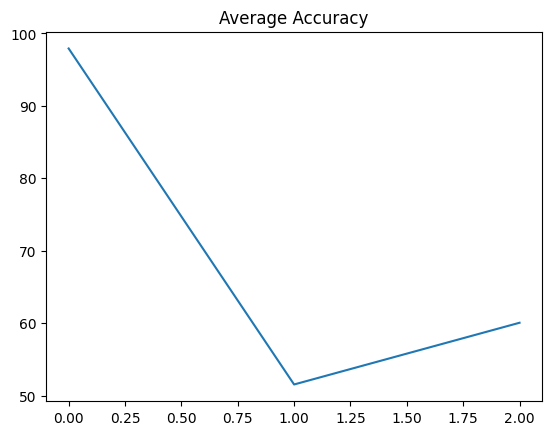

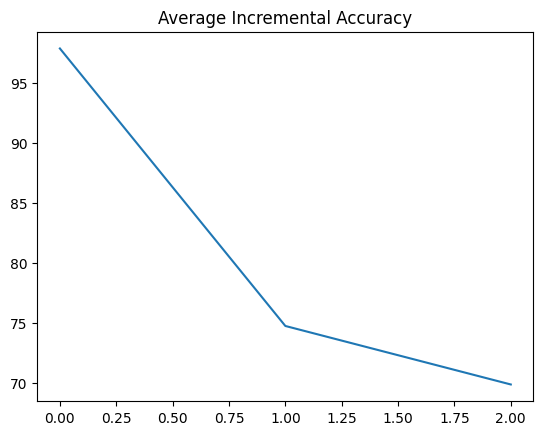

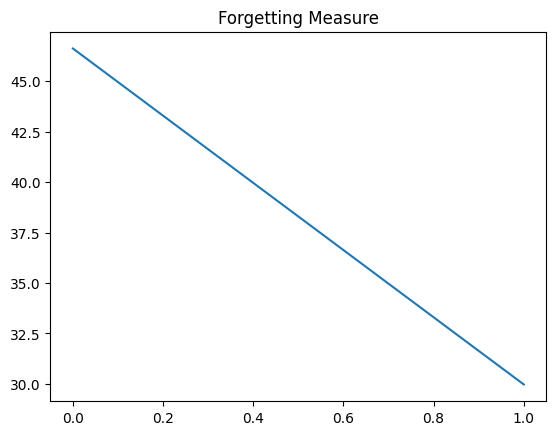

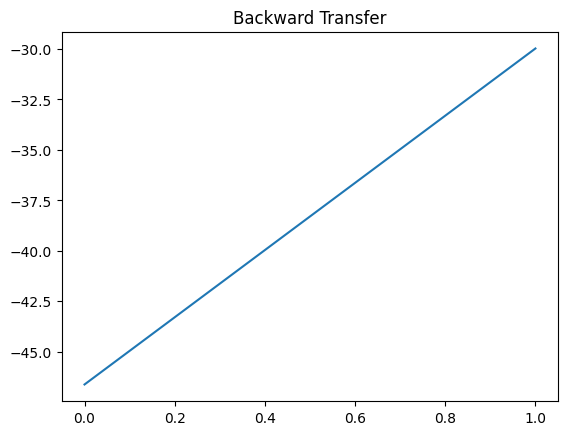

In [16]:
#@title Plot Results
plt.figure()
plt.title("Average Accuracy")
plt.plot(ave_accuracy)

plt.figure()
plt.title("Average Incremental Accuracy")
plt.plot(ave_inc_accuracy)

plt.figure()
plt.title("Forgetting Measure")
plt.plot(forgetting_measure)

plt.figure()
plt.title("Backward Transfer")
plt.plot(backward_transfer)

In [28]:
#@title Animation Function
def animate_all_MI(XH_data, YH_data, task_epochs):
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel('MI_X,H')
    ax.set_xlim([0, XH_data.max() + 0.5])
    ax.set_ylim([0, YH_data.max() + 0.1])
    ax.set_ylabel('MI_Y,H')
    title = ax.set_title('Information Plane')
    # Construct epoch colour map (for dots)
    tasks = len(task_epochs)
    epochs = XH_data.size()[0]
    cmap_dots = plt.get_cmap('gnuplot', tasks)
    dot_colors = []
    for task in range(len(task_epochs)):
        dot_colors += [cmap_dots(task)] * task_epochs[task]

    # Construct layer colour map (for lines)
    layers = XH_data.size()[1]
    cmap_lines = plt.get_cmap('tab10', layers)
    line_colors = [cmap_lines(i) for i in np.arange(0, layers)]

    # initiate plot
    plots = {'layer': [], 'epoch': []}
    for layer in range(layers):
        x = XH_data[0, layer]
        y = YH_data[0, layer]
        plots["layer"].append(ax.plot(x, y, '-', color=line_colors[layer], label="Layer " + str(layer+1)))
        plots["epoch"].append(ax.scatter(x, y, c=dot_colors[0]))

    def update(frame):
        # update axis data
        for layer in range(layers):
            x = XH_data[:frame,layer]
            y = YH_data[:frame,layer]
            plots["layer"][layer][0].set_xdata(x)
            plots["layer"][layer][0].set_ydata(y)
            data = np.stack([x,y]).T
            plots["epoch"][layer].set_offsets(data)
            plots["epoch"][layer].set_color(dot_colors[:frame])
        # update lines
    ani = animation.FuncAnimation(fig=fig, func=update, frames=XH_data.size()[0] + 10, interval=300)
    return ani

In [26]:
print(MI_XH)

tensor([[6.1134, 5.6765, 5.0605, 2.8712, 1.4603, 0.8427],
        [5.7297, 5.3064, 4.5175, 2.9377, 1.7785, 1.4771],
        [5.4574, 5.0652, 4.0099, 2.5830, 1.8298, 1.1865],
        [5.3232, 4.9567, 3.5860, 2.3984, 1.3318, 1.0952],
        [5.2971, 4.9173, 3.6060, 2.2390, 1.6120, 1.0741],
        [5.2846, 4.8537, 3.7116, 2.1042, 1.7951, 1.0559],
        [5.2642, 4.8370, 3.7085, 2.0993, 1.7878, 1.0443],
        [5.2447, 4.8179, 3.7121, 1.9025, 1.5608, 1.0430],
        [5.2184, 4.8070, 3.5774, 1.8422, 1.3966, 1.0360],
        [5.2033, 4.8377, 3.6151, 1.8212, 1.3541, 1.0330],
        [5.8377, 5.3456, 4.4058, 2.8137, 1.7285, 0.5950],
        [5.4597, 4.9737, 4.1668, 2.2977, 1.3900, 1.0664]])


[10, 1, 1]


<ipython-input-28-f8c33532e845>:68: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plots["epoch"].append(ax.scatter(x, y, c=dot_colors[0]))


<Figure size 640x480 with 0 Axes>

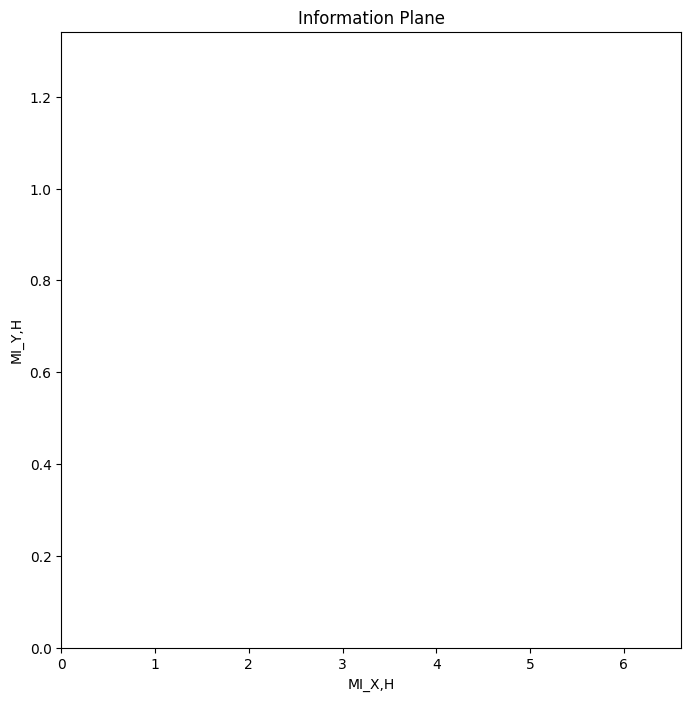

In [29]:
#@title Animation
task_epochs = [10] + [1] * (len(tasks)-1)
print(task_epochs)
ani = animate_all_MI(MI_XH, MI_YH, task_epochs)
ani.save("rehearsal_all_tasks.gif", writer="pillow")